In [11]:
import cv2
import numpy as np
from matplotlib import pyplot
import tensorflow as tf

from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"
print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

print("opencv :",cv2.__version__)
print("tensorflow :",tf.VERSION)

Show System RAM Memory:


MemTotal:        8041524 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11290988342220584656
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1542455296
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16491030724100641768
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
opencv : 4.1.1
tensorflow : 1.9.0


In [52]:
# prepare resize color image
def prepare_resize_image(file_name):
    color_img = cv2.imread(file_name)
    
    if fliter_out_gray_input(color_img) == False:
        return []
    
    
    resize_img = cv2.resize(color_img, desire_size)
#     gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
    
#     cv2.imshow("color_img", color_img)
#     cv2.imshow("resize_img", resize_img)
#     cv2.imshow("gray_img", gray_img)
#     cv2.waitKey(0)
    return resize_img

    
def fliter_out_gray_input(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    average = hsv_image.mean(axis=0).mean(axis=0)
    
    h_channel = hsv_image[:,:,0]
    
    h_channel = np.reshape(h_channel, len(h_channel)*len(h_channel[0]))
    h_average = sum(h_channel)/len(h_channel)
    h_max = max(h_channel)
    h_min = min(h_channel)
    
    print(h_average)
    print(h_max, h_min)
    
    if(h_max-h_min <= 50):
        return False
    
    return True
    


# prepare dataset
# the input file must be an array of images
def prepare_real_samples(file):
    # load compressed arrays
    # data = load(filename)
    # load the face dataset
    # color_images = data['arr_0'].astype('uint8')
    color_images = file
    
    # print(type(src_images))
    gray_images = color_images.astype('uint8')
    gray_images [:,:,:,0] = color_images[:,:,:,0]/3 + color_images[:,:,:,1]/3 + color_images[:,:,:,2]/3
    gray_images [:,:,:,1] = gray_images [:,:,:,0]
    gray_images [:,:,:,2] = gray_images [:,:,:,0]
    
    # unpack arrays
    X1 = gray_images
    X2 = color_images

    plot_images(color_images, 10)
#     plot_images(gray_images, 10)
    
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]


def plot_images(images, n):
    for i in range(n * n):
        if(i >= len(images)):
            break
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data # change from opencv-bgr to matplot-rgb
        pyplot.imshow(images[i][...,::-1].astype('uint8'))
    pyplot.show()


In [53]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from matplotlib.pyplot import figure
pyplot.rcParams['figure.figsize'] = [20, 10]


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


def summarize_performance(save_path, step, g_model, dataset, n_samples = 1):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i][...,::-1])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i][...,::-1])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i][...,::-1])
        
    pyplot.show()
    # save plot to file
#     filename1 = save_path + 'plot_%03d.png' % (step+1)
#     pyplot.savefig(filename1)
#     pyplot.close()


In [54]:
# prepare input_names
import os

test_images_path = "test_images"
desire_size = (256,256)
files = []

# r=root, d=directories, f = files
for r, d, f in os.walk(test_images_path):
    for file in f:
        files.append(os.path.join(r, file))
    
for f in files:
    print(f)

test_images/visual-reverse-image-search-v2_intro.jpg
test_images/students-in-class-696x462.jpg
test_images/ocean.jpg
test_images/Screenshot-2019-02-18-at-10.56.29.png
test_images/Healthy-food-including-lean-meats-low-fat-milk-whole-grains-and-vegetables.jpg
test_images/Healthy Food Made Easy -min.jpg
test_images/960x0.jpg
test_images/gray.jpeg
test_images/istockphoto-660726306-1024x1024.jpg
test_images/tales-from-the-trenches.jpg
test_images/0.jpg


75.96189107142857
179 0


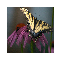

80.74050853361199
179 0


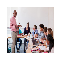

87.49547655453618
179 0


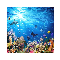

56.09210767989906
179 0


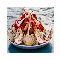

45.4802625
179 0


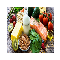

52.03515142857143
179 0


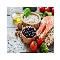

64.82547037760416
179 0


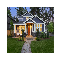

0.0
0 0
20.926319740118895
27 13
37.889770305470044
179 0


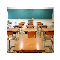

63.86203979802799
179 0


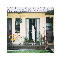

In [57]:
from numpy import asarray

for file in files:

    resize_img = prepare_resize_image(file)
    if len(resize_img) == 0:
        continue
    dataset = prepare_real_samples(asarray([resize_img])) # the input must be a list
